# 评论生成-seq2seq with attention

In [1]:
import torch
import os
from torch import nn
from d2l import torch as d2l

In [ ]:
# colab 连接Google driver
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# colab 安装
# %matplotlib inline
# !pip install d2l
# !pip install matplotlib==3.6.0
# !pip install matplotlib_inline==0.1.6

In [ ]:
# colab 导入
# import torch
# import os
# from torch import nn
# from d2l import torch as d2l 

## Decoder with Attention

In [2]:
# attention
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制解码器的基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError
        
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size,
        # num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            # 这里的x就是一个token 所以num_step都是1
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            # 这里的context就已经是找到最相关的hidden state了
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结 和之前一样decoder的输入是X与hide state上下拼接
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [3]:
# colab 需要修改data路径
def read_data_nmt():
    # commentGeneration(train数据集) 2023年3月23日00:16:37
    with open(os.path.join("data\\codeReviewer\\commentsGeneration", 'valid_trainPair.txt'), 'r', encoding='utf-8') as f:
        return f.read()
    
def preprocess_nmt(text):
    """预处理数据中特殊符号"""
    def no_space(char, prev_char):
        return char in set('·') and prev_char != ' '
    # 董政宇 2022年10月24日20:56:44 修改lower()
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

def load_data_nmt(batch_size, num_steps, num_examples=600):
    """加载批量数据"""
    text = preprocess_nmt(read_data_nmt())
    source, target = d2l.tokenize_nmt(text, num_examples)
    # min_freq 调整了一下
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = d2l.build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = d2l.build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

def read_test_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read().splitlines()


## 数据分析  超参数num_steps

In [4]:
# 数据集获取 comment and code
# colab 数据集路径： /content/drive/MyDrive/
source, target = d2l.tokenize_nmt(preprocess_nmt(read_data_nmt()))
source[:2], target[:2]

([['NEWLINE_NJUPT',
   'KEEP_NJUPT',
   'def',
   'setup_app',
   '(',
   'app',
   ')',
   ':',
   'NEWLINE_NJUPT',
   'KEEP_NJUPT',
   ')',
   'NEWLINE_NJUPT',
   'KEEP_NJUPT',
   'return',
   'rv',
   'NEWLINE_NJUPT',
   'KEEP_NJUPT',
   'NEWLINE_NJUPT',
   'ADD_NJUPT',
   '@',
   'app',
   '.',
   'template_test',
   '(',
   "'list'",
   ')',
   'NEWLINE_NJUPT',
   'ADD_NJUPT',
   'def',
   '_is_list',
   '(',
   'value',
   ')',
   ':',
   'NEWLINE_NJUPT',
   'ADD_NJUPT',
   'return',
   'isinstance',
   '(',
   'value',
   ',',
   'list',
   ')',
   'NEWLINE_NJUPT',
   'ADD_NJUPT',
   'NEWLINE_NJUPT',
   'KEEP_NJUPT',
   'return',
   'app'],
  ['NEWLINE_NJUPT',
   'KEEP_NJUPT',
   'namespace',
   'OpenTelemetry',
   '.',
   'Trace',
   'NEWLINE_NJUPT',
   'KEEP_NJUPT',
   'configureSqlClientInstrumentationOptions',
   '?',
   '.',
   'Invoke',
   '(',
   'sqlOptions',
   ')',
   ';',
   'NEWLINE_NJUPT',
   'KEEP_NJUPT',
   'NEWLINE_NJUPT',
   'KEEP_NJUPT',
   'builder',
   '.',
 

10319


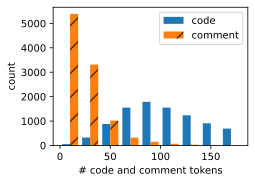

In [5]:
# 绘图选参
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """绘制列表长度对的直方图"""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist([[len(l) for l in xlist], [len(l) for l in ylist]], bins=range(0, 200, 20))
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

show_list_len_pair_hist(['code', 'comment'], '# code and comment tokens', 'count', source, target);
print(len(source))

## start train

loss 0.002, 2550.0 tokens/sec on cuda:0


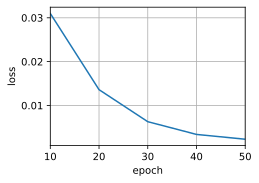

In [6]:
# 超参数设置合适的
embed_size, num_hiddens, num_layers, dropout = 128, 128, 2, 0.1
batch_size, num_steps = 32, 100
lr, num_epochs, device = 0.005, 50, d2l.try_gpu()

# 读取数据 我在d2l.load_data_nmt中更改了代码
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)

# encoder 还是那个，只是把attention 应用到decoder上，对其做出修改
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)

net = d2l.EncoderDecoder(encoder, decoder)
# 开始训练
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## 1.验证数据集BLUE

In [53]:
codes = read_test_data('data\\codeReviewer\\commentsGeneration\\valid_codeTokens.txt')
comments = read_test_data('data\\codeReviewer\\commentsGeneration\\valid_msgTokens.txt')
normal_codes = read_test_data('data\\codeReviewer\\commentsGeneration\\valid_code.txt')

sum_blue = 0
for code, comment, normal_code in zip(codes, comments, normal_codes):
    
    predict_comment, dec_attention_weight_seq = d2l.predict_seq2seq(net, code, src_vocab, tgt_vocab, num_steps, device, True)
    
    if d2l.bleu(predict_comment, comment, k=2) >= 2:
        normal_code = normal_code.replace("NEWLINE_NJUPT ADD_NJUPT", "\n+", )
        normal_code = normal_code.replace("NEWLINE_NJUPT DEL_NJUPT", "\n-",)
        normal_code = normal_code.replace("NEWLINE_NJUPT KEEP_NJUPT", "\n")
        normal_code = normal_code.replace("TABLE_NJUPT", "\t")
        sum_blue = sum_blue + round(d2l.bleu(predict_comment, comment, k=2), 3)
#         print("*****************************************************************************************************")
#         print(f'{normal_code} \n\n==>True comment: {comment}\n==>Predicted comment:{predict_comment}, ',
#               f'\n==>bleu {d2l.bleu(predict_comment, comment, k=2):.3f} \n')
        
print('平均blue: {:.3f}'.format(sum_blue/len(codes)))

KeyboardInterrupt: 

## 2.测试数据集BLUE

In [52]:
codes = read_test_data('data\\codeReviewer\\commentsGeneration\\test_codeTokens.txt')
comments = read_test_data('data\\codeReviewer\\commentsGeneration\\test_msgTokens.txt')
normal_codes = read_test_data('data\\codeReviewer\\commentsGeneration\\test_code.txt')

sum_blue = 0
for code, comment, normal_code in zip(codes, comments, normal_codes):
    
    predict_comment, dec_attention_weight_seq = d2l.predict_seq2seq(net, code, src_vocab, tgt_vocab, num_steps, device, True)
    
    if d2l.bleu(predict_comment, comment, k=2) >= 2:
        normal_code = normal_code.replace("NEWLINE_NJUPT ADD_NJUPT", "\n+", )
        normal_code = normal_code.replace("NEWLINE_NJUPT DEL_NJUPT", "\n-",)
        normal_code = normal_code.replace("NEWLINE_NJUPT KEEP_NJUPT", "\n")
        normal_code = normal_code.replace("TABLE_NJUPT", "\t")
        sum_blue = sum_blue + round(d2l.bleu(predict_comment, comment, k=2), 3)
#         print("*****************************************************************************************************")
#         print(f'{normal_code} \n\n==>True comment: {comment}\n==>Predicted comment:{predict_comment}, ',
#               f'\n==>bleu {d2l.bleu(predict_comment, comment, k=2):.3f} \n')
        
print('平均blue: {:.3f}'.format(sum_blue/len(codes)))

平均blue: 0.019


# 训练数据 accuracy

In [6]:
engs_input = read_test_data('data\\codeReviewer\\commentsGeneration\\codeTokens.txt')
fras_truth = read_test_data('data\\codeReviewer\\commentsGeneration\\msgTokens.txt')

count_acc = 0
count_all = 0
for eng, fra in zip(engs_input, fras_truth):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
#     print(f'\n{eng}\n => {translation}\n, ',
#           f'bleu {d2l.bleu(translation, fra, k=2):.3f}')
    if d2l.bleu(translation, fra, k=2) >= 1:
        count_acc = count_acc + 1
    count_all = count_all + 1
        
#     print(f'{d2l.bleu(translation, fra, k=2):.3f}')
result = (count_acc/count_all)*100
print(f"总共测试了{count_all}组数据，其中正确预测了{count_acc}个，综合精度为{round(result, 1)}%")

总共测试了793组数据，其中正确预测了73个，综合精度为9.2%
